In [3]:
import polars as pl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from pathlib import Path
import gc
from tqdm import tqdm
import math
from lightgbm import LGBMRegressor, plot_importance
from sklearn.metrics import r2_score
from prj.config import DATA_DIR
from prj.data.data_loader import DataConfig, DataLoader

2024-12-24 18:48:45.600539: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-24 18:48:45.600571: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-24 18:48:45.664805: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-24 18:48:45.812762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-24 18:48:47.170411: W tensorflow/compiler/tf2

In [4]:
def evaluate_model(model, X_train, y_train, X_val, y_val, weights, feature_names):   
    model.fit(X_train, y_train, feature_name=feature_names)
    pred_val = model.predict(X_val).clip(-5, 5)
    return r2_score(y_val, pred_val, sample_weight=weights)

In [5]:
def build_splits(df: pl.LazyFrame, features):
    X = df.select(features).cast(pl.Float32).collect().to_numpy()
    y = df.select('responder_6').cast(pl.Float32).collect().to_series().to_numpy()
    w = df.select('weight').cast(pl.Float32).collect().to_series().to_numpy()
    return X, y, w

In [6]:
from prj.data.data_loader import PARTITIONS_DATE_INFO


data_args = {}
config = DataConfig(**data_args)
loader = DataLoader(data_dir=DATA_DIR, config=config)
start_dt, end_dt = PARTITIONS_DATE_INFO[8]['min_date'], PARTITIONS_DATE_INFO[9]['max_date']

complete_ds = loader.load(start_dt=start_dt, end_dt=end_dt)
features = loader.features

start_val_date = PARTITIONS_DATE_INFO[9]['min_date']

In [7]:
params = {'n_estimators': 200, 'max_depth': 3, 'num_leaves': 8, 'learning_rate': 5e-2}

In [8]:
model = LGBMRegressor(**params)
train_ds = complete_ds.filter(pl.col('date_id') < start_val_date)
val_ds = complete_ds.filter(pl.col('date_id') >= start_val_date)

X_train, y_train, w_train = build_splits(train_ds, features=features)
X_val, y_val, w_val = build_splits(val_ds, features=features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.694162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 19354
[LightGBM] [Info] Number of data points in the train set: 6140024, number of used features: 79
[LightGBM] [Info] Start training from score 0.001341


0.004925303885731869

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

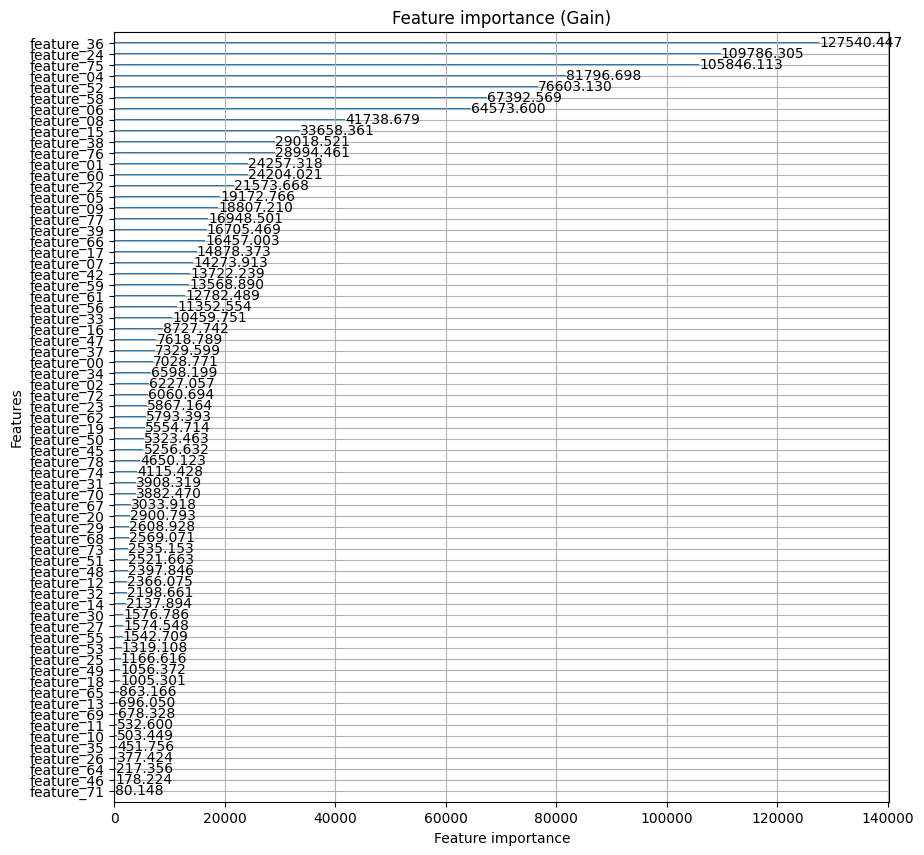

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

In [10]:
del X_train, y_train, w_train, X_val, y_val, w_val, model
gc.collect()

35

# Aggregations

In [11]:
MEAN_FEATURES = [0, 2, 3, 5, 6, 7, 18, 19, 34, 35, 36, 37, 38, 41, 43, 44, 48, 53, 55, 59, 62, 65, 68, 73, 74, 75, 76, 77, 78]
STD_FEATURES = [39, 42, 46, 53, 57, 66]
SKEW_FEATURES = [5, 40, 41, 42, 43, 44]
ZSCORE_FEATURES = [1, 36, 40, 45, 48, 49, 51, 52, 53, 54, 55, 59, 60]
def _include_intrastock_norm(df: pl.LazyFrame) -> pl.LazyFrame:
    df = df.with_columns(
        pl.col([f'feature_{j:02d}' for j in set(MEAN_FEATURES + ZSCORE_FEATURES)]).mean().over(['date_id', 'time_id']).name.suffix('_mean'),
        pl.col([f'feature_{j:02d}' for j in set(STD_FEATURES + ZSCORE_FEATURES)]).std().over(['date_id', 'time_id']).name.suffix('_std'),
        pl.col([f'feature_{j:02d}' for j in SKEW_FEATURES]).skew().over(['date_id', 'time_id']).name.suffix('_skew'),
    ).with_columns(
        pl.col(f'feature_{j:02d}').sub(f'feature_{j:02d}_mean').truediv(f'feature_{j:02d}_std').name.suffix('_zscore') for j in ZSCORE_FEATURES
    ).drop([f'feature_{j:02d}_std' for j in ZSCORE_FEATURES if j not in STD_FEATURES] + \
        [f'feature_{j:02d}_mean' for j in ZSCORE_FEATURES if j not in MEAN_FEATURES])
    
    return df

df = _include_intrastock_norm(complete_ds)

In [12]:
model = LGBMRegressor(**params)

train_ds = df.filter(pl.col('date_id') < start_val_date)
val_ds = df.filter(pl.col('date_id') >= start_val_date)

curr_features = features +  [f'feature_{j:02d}_mean' for j in MEAN_FEATURES] + \
        [f'feature_{j:02d}_std' for j in STD_FEATURES] + [f'feature_{j:02d}_skew' for j in SKEW_FEATURES] + \
        [f'feature_{j:02d}_zscore' for j in ZSCORE_FEATURES]
        
X_train, y_train, w_train = build_splits(train_ds, features=curr_features)
X_val, y_val, w_val = build_splits(val_ds, features=curr_features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, curr_features)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.284298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 33124
[LightGBM] [Info] Number of data points in the train set: 6140024, number of used features: 133
[LightGBM] [Info] Start training from score 0.001341


0.005754882025349017

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

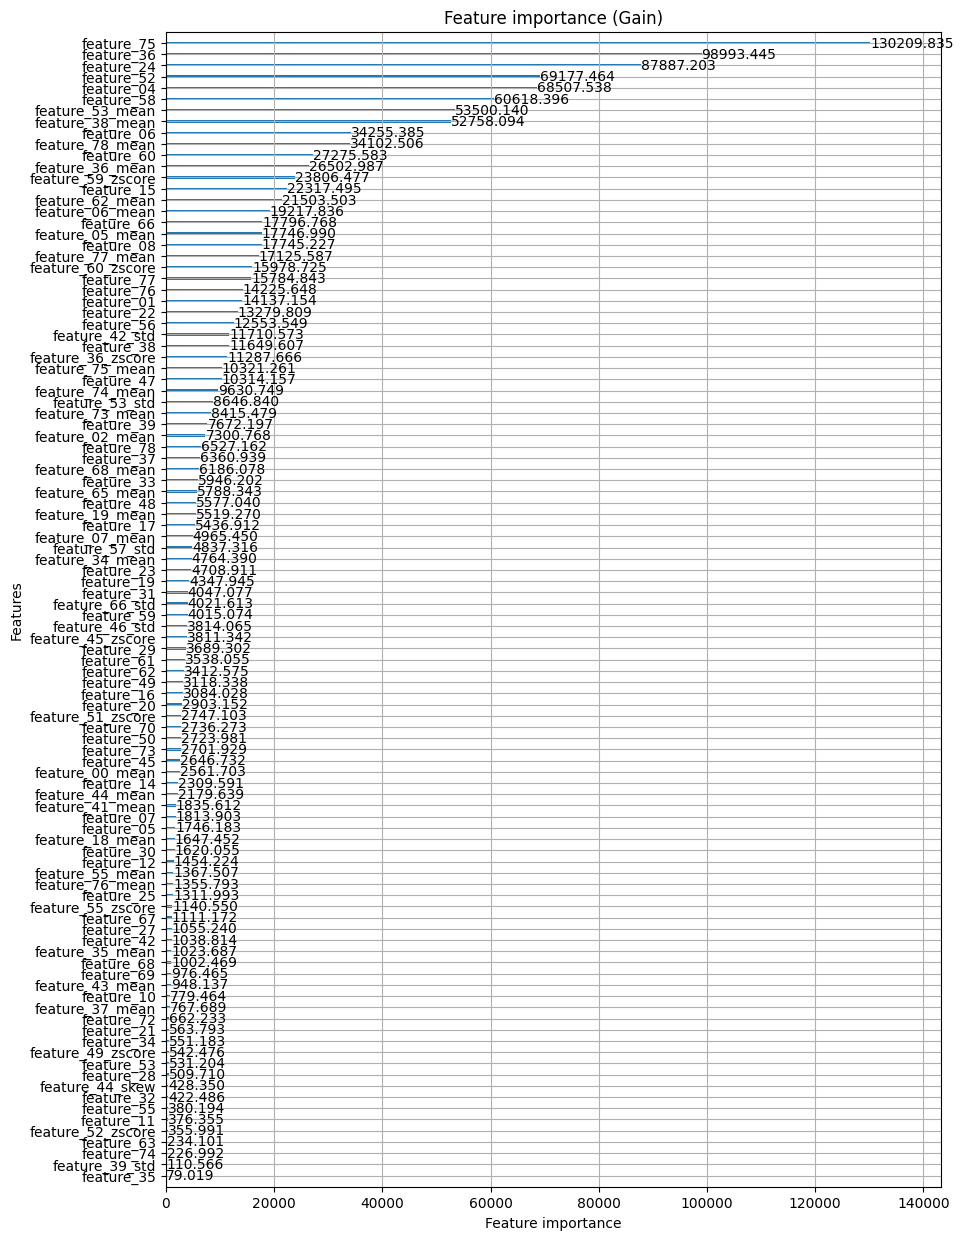

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)

# TopK stock features

In [11]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from prj.utils import wrapper_pbar

def _fn(df: pl.DataFrame, period, responder, schema, top_k) -> pl.DataFrame:
    min_date = df['date_id'].min()
    max_date = df['date_id'].max()
    
    if max_date - min_date != period:
        return pl.DataFrame({}, schema=schema)
    
    # print(min_date, max_date)
    pivot = df.filter(pl.col('date_id') < max_date)\
        .pivot(index=['date_id', 'time_id'], values=[responder], separator='_', on='symbol_id')\
        .fill_nan(None)\
        .fill_null(strategy='zero')
    res = df.select('date_id', 'time_id', 'symbol_id').filter(pl.col('date_id') == max_date)
    
    cols = [col for col in pivot.columns if col not in ['date_id', 'time_id']]
    stocks = np.array([int(col) for col in cols])
    
    corr_matrix = pivot.select(cols).corr().cast(pl.Float32).to_numpy()
    np.fill_diagonal(corr_matrix, -np.inf)
    top_k_indices = np.argsort(-corr_matrix, axis=1)[:, :top_k]
    top_stocks = stocks[top_k_indices]
    stock_topk_mapping = dict(zip(stocks, top_stocks))
    
    # print(stock_topk_mapping)
    curr_stocks = res['symbol_id'].unique().to_numpy()
    res = pl.DataFrame({'date_id': [max_date] * len(curr_stocks), 'symbol_id': curr_stocks})
    res = res.with_columns(
        pl.col('symbol_id').replace_strict(
            stock_topk_mapping,
            default=list(stocks),
            return_dtype=pl.List(pl.Int8)
        ).alias(f'{responder}_top_{top_k}')
    )
    
    return res.cast(schema)


responder = 'responder_6'
top_k = 5
period=7

schema = {'date_id': pl.Int16, 'symbol_id': pl.Int8, f'{responder}_top_{top_k}': pl.List(pl.Int8)}


n_days = complete_ds.select('date_id').collect().n_unique()
with tqdm(total=int(n_days)) as pbar:
    _df = complete_ds.select('date_id', 'time_id', 'symbol_id', responder).sort('date_id').group_by_dynamic(
        pl.col('date_id').cast(pl.Int64),
        period=f'{period}i',
        every='1i',
        closed='both',
    ).map_groups(
        wrapper_pbar(
            pbar, 
            lambda df: _fn(df, period=period, responder=responder, schema=schema, top_k=top_k),
        ),
        schema=schema
    ).collect()
    
_df

100%|██████████| 339/339 [00:41<00:00,  8.11it/s]


date_id,symbol_id,responder_6_top_5
i16,i8,list[i8]
1367,0,"[7, 1, … 9]"
1367,1,"[0, 16, … 9]"
1367,2,"[30, 5, … 8]"
1367,3,"[19, 22, … 5]"
1367,4,"[38, 14, … 31]"
…,…,…
1698,34,"[10, 36, … 26]"
1698,35,"[33, 0, … 7]"
1698,36,"[10, 6, … 26]"


In [ ]:
_df['responder_6_top_5'].null_count()

In [13]:
df = complete_ds.join(_df.lazy(), on=['date_id', 'symbol_id'], how='left').collect()
df

date_id,time_id,symbol_id,weight,feature_00,feature_01,feature_02,feature_03,feature_04,feature_05,feature_06,feature_07,feature_08,feature_09,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,…,feature_53,feature_54,feature_55,feature_56,feature_57,feature_58,feature_59,feature_60,feature_61,feature_62,feature_63,feature_64,feature_65,feature_66,feature_67,feature_68,feature_69,feature_70,feature_71,feature_72,feature_73,feature_74,feature_75,feature_76,feature_77,feature_78,responder_0,responder_1,responder_2,responder_3,responder_4,responder_5,responder_6,responder_7,responder_8,partition_id,responder_6_top_5
i16,i16,i8,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i8,i8,i16,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,i64,list[i8]
1360,0,0,1.865621,2.891473,0.353332,1.668053,2.853531,3.41232,-1.245219,1.179884,0.709263,0.784449,11,7,76,-0.711437,2.205213,0.024286,null,-0.18582,null,-0.776699,-1.427152,-0.106673,-0.18906,1.171838,0.77466,0.049445,0.042497,0.859838,0.686105,0.107406,-0.446071,-0.396082,-0.190675,null,…,null,-1.229728,null,-2.179146,1.302607,null,-1.032147,-0.63119,-2.038523,-0.189215,-0.220136,-0.3924,-1.135486,-1.661633,-0.790606,1.890215,0.001349,-1.058679,2.247464,0.07354,null,null,-0.03963,-0.084874,-0.279023,-0.352222,0.502829,0.115287,-0.313245,0.651638,-1.308276,-1.620408,0.374767,-1.049378,-2.496996,8,null
1360,0,1,1.82383,3.157964,0.191611,2.494816,2.845078,3.090568,-0.742658,0.964224,0.692671,1.15839,11,7,76,-0.579026,5.287416,0.753263,null,-0.629359,null,-1.723243,-1.795245,-0.448737,0.015463,0.541579,0.330938,-0.002957,-0.20329,-1.289421,-0.514872,0.273925,-0.443356,-0.530671,0.023403,null,…,null,-0.839805,null,-0.93908,2.254601,null,-0.545372,-0.234116,-2.038523,-0.334274,-0.425932,-0.245547,-1.028174,-1.485761,-0.6036,5.201469,0.950863,-0.619285,2.046141,0.338139,null,null,0.074365,0.07962,-0.157968,-0.212594,0.351176,-0.131981,0.12753,0.053275,-0.241975,-0.027899,-0.184599,-0.21643,-0.182844,8,null
1360,0,2,1.411181,2.71605,0.03601,1.96654,2.863158,2.959575,-1.340717,1.497796,1.125183,1.433874,81,2,59,-0.717919,1.761788,-0.269296,null,-0.376454,null,-2.164926,-1.315706,-0.851814,-0.274073,-0.161511,-0.387801,-0.428675,-0.849509,0.65201,0.264918,-0.209389,-0.984805,-0.524969,-0.219953,null,…,null,-1.041321,null,-1.244292,1.72838,null,-0.477953,0.056212,-2.038523,-0.159238,-0.271364,-0.120655,-1.69848,-2.256913,-0.882069,1.865896,-0.183403,-1.05608,0.741354,-0.314237,null,null,2.663223,3.058135,3.308958,3.219775,-0.88357,-0.445202,0.102318,-0.391579,-0.871908,0.363652,0.236567,-1.445096,0.506134,8,null
1360,0,3,1.544636,2.70418,0.410197,2.214327,3.090716,3.155712,-0.923788,1.072018,0.611664,0.544632,4,3,11,-1.119727,1.647872,-0.212084,null,-0.119922,null,-0.801926,-1.482203,0.413664,-0.039512,-0.177877,-0.495196,1.19062,2.080005,-0.448234,-0.991314,-0.659872,-0.602899,-0.717945,-0.036078,null,…,null,-1.676184,null,-2.514656,0.632661,null,-3.623972,-2.102605,-2.038523,-0.418656,-0.207589,-0.233005,-1.425519,-2.173582,-0.475477,1.469188,-0.119621,-1.102054,0.880262,-0.237961,null,null,3.390588,3.426589,0.2715,0.281109,-0.52451,-0.459967,-0.971227,-0.524694,0.761837,-1.442856,-0.447208,0.857494,-1.468352,8,null
1360,0,4,1.061685,2.375254,0.886124,2.317989,3.283024,2.975022,-1.422651,1.928834,0.656916,1.251032,15,1,9,-0.67994,2.329011,0.108222,null,-0.160354,null,-0.930074,-2.637479,-0.868251,-0.08283,-0.486203,-0.575452,-0.360617,-0.467982,-1.785965,-1.317007,-0.438635,-0.598094,-0.625449,-0.086514,null,…,null,-2.599928,null,-2.114797,0.219253,null,-5.716918,-3.479656,-2.038523,-0.294526,-0.15618,-0.303663,-1.218586,-1.581481,-

In [12]:
df.group_by('date_id', 'symbol_id')

date_id,symbol_id,responder_6_top_5
i16,i8,list[i8]
1367,0,"[7, 1, … 9]"


# Group correlation features

In [25]:
complete_ds = loader.load(850, 1550)
n_days = complete_ds.select('date_id').collect().n_unique()
n_days

701

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster

from prj.utils import wrapper_pbar

def _test(df: pl.DataFrame, period, responders, schema) -> pl.DataFrame:
    min_date = df['date_id'].min()
    max_date = df['date_id'].max()
    
    if max_date - min_date != period:
        return pl.DataFrame({}, schema=schema)
    
    # print(min_date, max_date)
    pivot = df.filter(pl.col('date_id') < max_date)\
        .pivot(index=['date_id', 'time_id'], values=responders, separator='_', on='symbol_id')\
        .fill_nan(None)\
        .fill_null(strategy='zero')
    res = df.select('date_id', 'time_id', 'symbol_id').filter(pl.col('date_id') == max_date)
    
    for responder in responders:
        cols = [col for col in pivot.columns if responder in col]
        stocks = [int(col.split('_')[-1]) for col in cols]
        
        df_corr_responder = pivot.select(cols).corr()
        linked = linkage(df_corr_responder, method='ward')
        cluster_labels = fcluster(linked, t=2.5, criterion='distance')
    
        res = res.with_columns(
            pl.col('symbol_id').replace_strict(old=stocks, new=cluster_labels, default=-1, return_dtype=pl.Int8).alias(f'cluster_label_{responder}')
        )
        
    return res.cast(schema)


responders = [f'responder_{i}' for i in range(1, 9)]
schema = {'date_id': pl.Int16, 'time_id': pl.Int16, 'symbol_id': pl.Int8}
for responder in responders:
    schema[f'cluster_label_{responder}'] = pl.Int8
    
period=7

n_days = complete_ds.select('date_id').collect().n_unique()
with tqdm(total=int(n_days)) as pbar:
    clusters = complete_ds.select('date_id', 'time_id', 'symbol_id', *responders).sort('date_id').group_by_dynamic(
        pl.col('date_id').cast(pl.Int64),
        period=f'{period}i',
        every='1i',
        closed='both',
    ).map_groups(
        wrapper_pbar(
            pbar, 
            lambda df: _test(df, period=period, responders=responders, schema=schema),
        ),
        schema=schema
    ).collect()
    
clusters

 81%|████████  | 548/680 [01:06<00:15,  8.27it/s]


ComputeError: User provided python function failed: KeyboardInterrupt: 

In [34]:
clusters.describe()

statistic,date_id,time_id,symbol_id,cluster_label_responder_1,cluster_label_responder_2,cluster_label_responder_3,cluster_label_responder_4,cluster_label_responder_5,cluster_label_responder_6,cluster_label_responder_7,cluster_label_responder_8
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7,1.2151304e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",1534.077033,483.5,18.996176,3.557476,1.078547,2.421254,3.23596,1.892137,2.581056,3.434956,2.026687
"""std""",95.687109,279.437393,11.237335,1.928929,0.273436,1.099322,1.708342,0.667911,1.033794,1.694108,0.640395
"""min""",1367.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
"""25%""",1452.0,242.0,9.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0
"""50%""",1535.0,484.0,19.0,3.0,1.0,2.0,3.0,2.0,3.0,3.0,2.0
"""75%""",1617.0,725.0,29.0,5.0,1.0,3.0,5.0,2.0,3.0,5.0,2.0
"""max""",1698.0,967.0,38.0,11.0,2.0,5.0,8.0,3.0,6.0,8.0,5.0


In [35]:
cluster_label_cols = [f'cluster_label_responder_{i}' for i in range(1, 9)]

df = complete_ds.join(
    clusters.lazy(), on=['date_id', 'time_id', 'symbol_id'], how='left'
).with_columns(
    pl.col(cluster_label_cols).fill_null(-1)
)

In [36]:
MEAN_FEATURES = [0, 2, 3, 5, 6, 7, 18, 19, 34, 35, 36, 37, 38, 41, 43, 44, 48, 53, 55, 59, 62, 65, 68, 73, 74, 75, 76, 77, 78]
STD_FEATURES = [39, 42, 46, 53, 57, 66]
SKEW_FEATURES = [5, 40, 41, 42, 43, 44]
ZSCORE_FEATURES = [1, 36, 40, 45, 48, 49, 51, 52, 53, 54, 55, 59, 60]
def _include_intrastock_norm(df: pl.LazyFrame, responder) -> pl.LazyFrame:
    df = df.with_columns(
        pl.col([f'feature_{j:02d}' for j in set(MEAN_FEATURES + ZSCORE_FEATURES)]).mean().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_mean'),
        pl.col([f'feature_{j:02d}' for j in set(STD_FEATURES + ZSCORE_FEATURES)]).std().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_std'),
        pl.col([f'feature_{j:02d}' for j in SKEW_FEATURES]).skew().over(['date_id', 'time_id', f'cluster_label_{responder}']).name.suffix(f'_{responder}_skew'),
    ).with_columns(
        pl.col(f'feature_{j:02d}').sub(f'feature_{j:02d}_{responder}_mean').truediv(f'feature_{j:02d}_{responder}_std').name.suffix(f'_{responder}_zscore') for j in ZSCORE_FEATURES
    ).drop([f'feature_{j:02d}_{responder}_std' for j in ZSCORE_FEATURES if j not in STD_FEATURES] + \
        [f'feature_{j:02d}_{responder}_mean' for j in ZSCORE_FEATURES if j not in MEAN_FEATURES])
    
    return df

df = _include_intrastock_norm(df, 'responder_6')

df = df.drop(cluster_label_cols)

In [37]:
model = LGBMRegressor(**params)

train_ds = df.filter(pl.col('date_id') < start_val_date)
val_ds = df.filter(pl.col('date_id') >= start_val_date)

curr_features = [col for col in df.collect_schema().keys() if col.startswith('feature_')]
print(curr_features)
        
X_train, y_train, w_train = build_splits(train_ds, features=curr_features)
X_val, y_val, w_val = build_splits(val_ds, features=curr_features)

evaluate_model(model, X_train, y_train, X_val, y_val, w_val, curr_features)

['feature_00', 'feature_01', 'feature_02', 'feature_03', 'feature_04', 'feature_05', 'feature_06', 'feature_07', 'feature_08', 'feature_09', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24', 'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29', 'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34', 'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39', 'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44', 'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49', 'feature_50', 'feature_51', 'feature_52', 'feature_53', 'feature_54', 'feature_55', 'feature_56', 'feature_57', 'feature_58', 'feature_59', 'feature_60', 'feature_61', 'feature_62', 'feature_63', 'feature_64', 'feature_65', 'feature_66', 'feature_67', 'feature_68', 'feature_69', 'feature_70', 'feat

0.00596621086026905

<Axes: title={'center': 'Feature importance (Gain)'}, xlabel='Feature importance', ylabel='Features'>

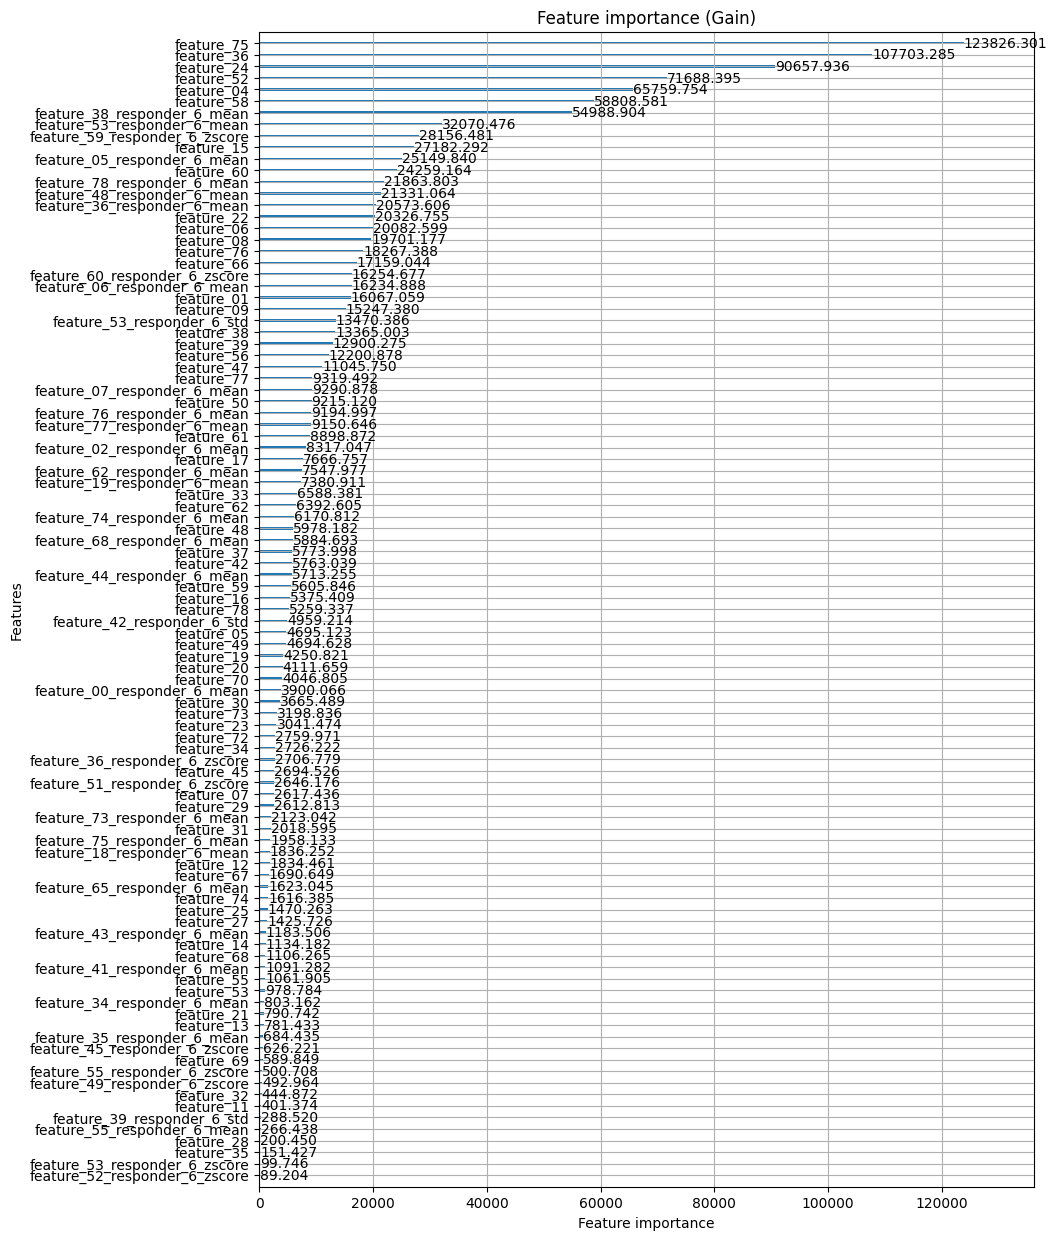

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
plot_importance(model, importance_type='gain', title='Feature importance (Gain)', ax=ax)